<a href="https://colab.research.google.com/github/jyslord/colab/blob/main/baseflow_lstm_30lag_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 12.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


1.15.2
(15960, 30, 2)
(15960, 1)
(10000, 30, 2)
(960, 30, 2)
(10000, 1)
(960, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 10000 samples, validate on 5000 samples
Epoch 1/1000
10000/10000 [==============================] - 8s 817us/step - loss: 3185.7043 - mae: 28.8178 - val_loss: 3865.6318 - val_mae: 28.0843
Epoch 2/1000
10000/10000 [==============================] - 7s 674us/step - loss: 3019.0580 - mae: 26.6574 - val_loss: 3763.7808 - val_mae: 27.2813
Epoch 3/1000
10000/10000 [==============================] - 7s 675us/step - loss: 2950.9971 - mae: 25.9871 - val_loss: 3713.7613 - val_mae: 26.9987
Epoch 4/1000
10000/10000 [==============================] - 8s 828us/step - loss: 2907.5513 - mae: 25.6442 - val_loss: 3674.4143 - val_mae: 26.8201
Epoch 5/1000
10000/10000 [==============================] - 7s 682us/step - loss: 2871.6287 - mae: 25.3796 - val_loss: 3639.0221 - val_mae: 26.6898
Epoch 6/1000
10000/10000 [======================

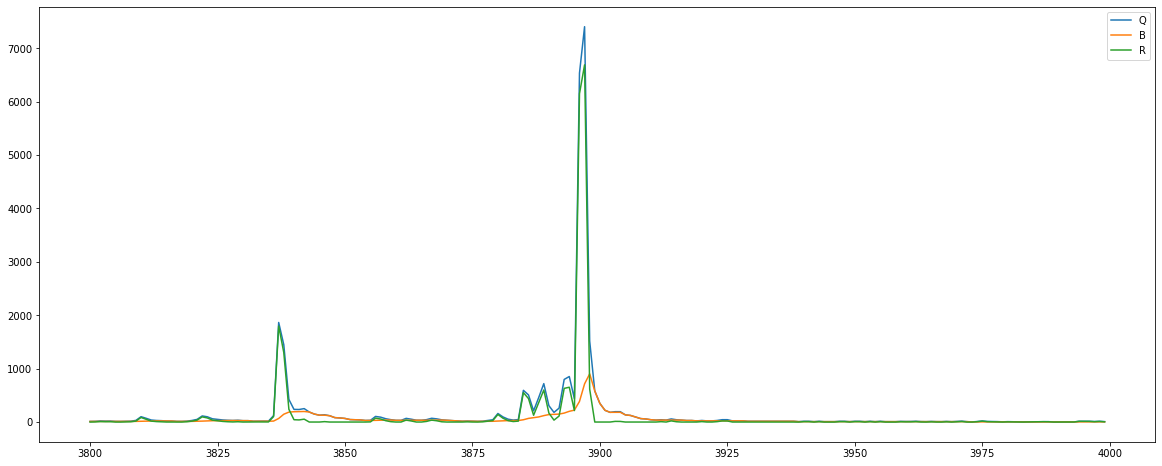

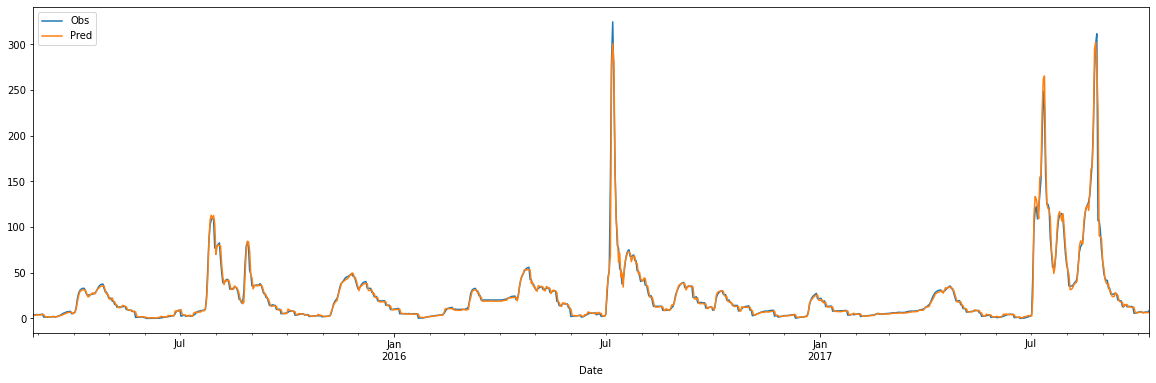

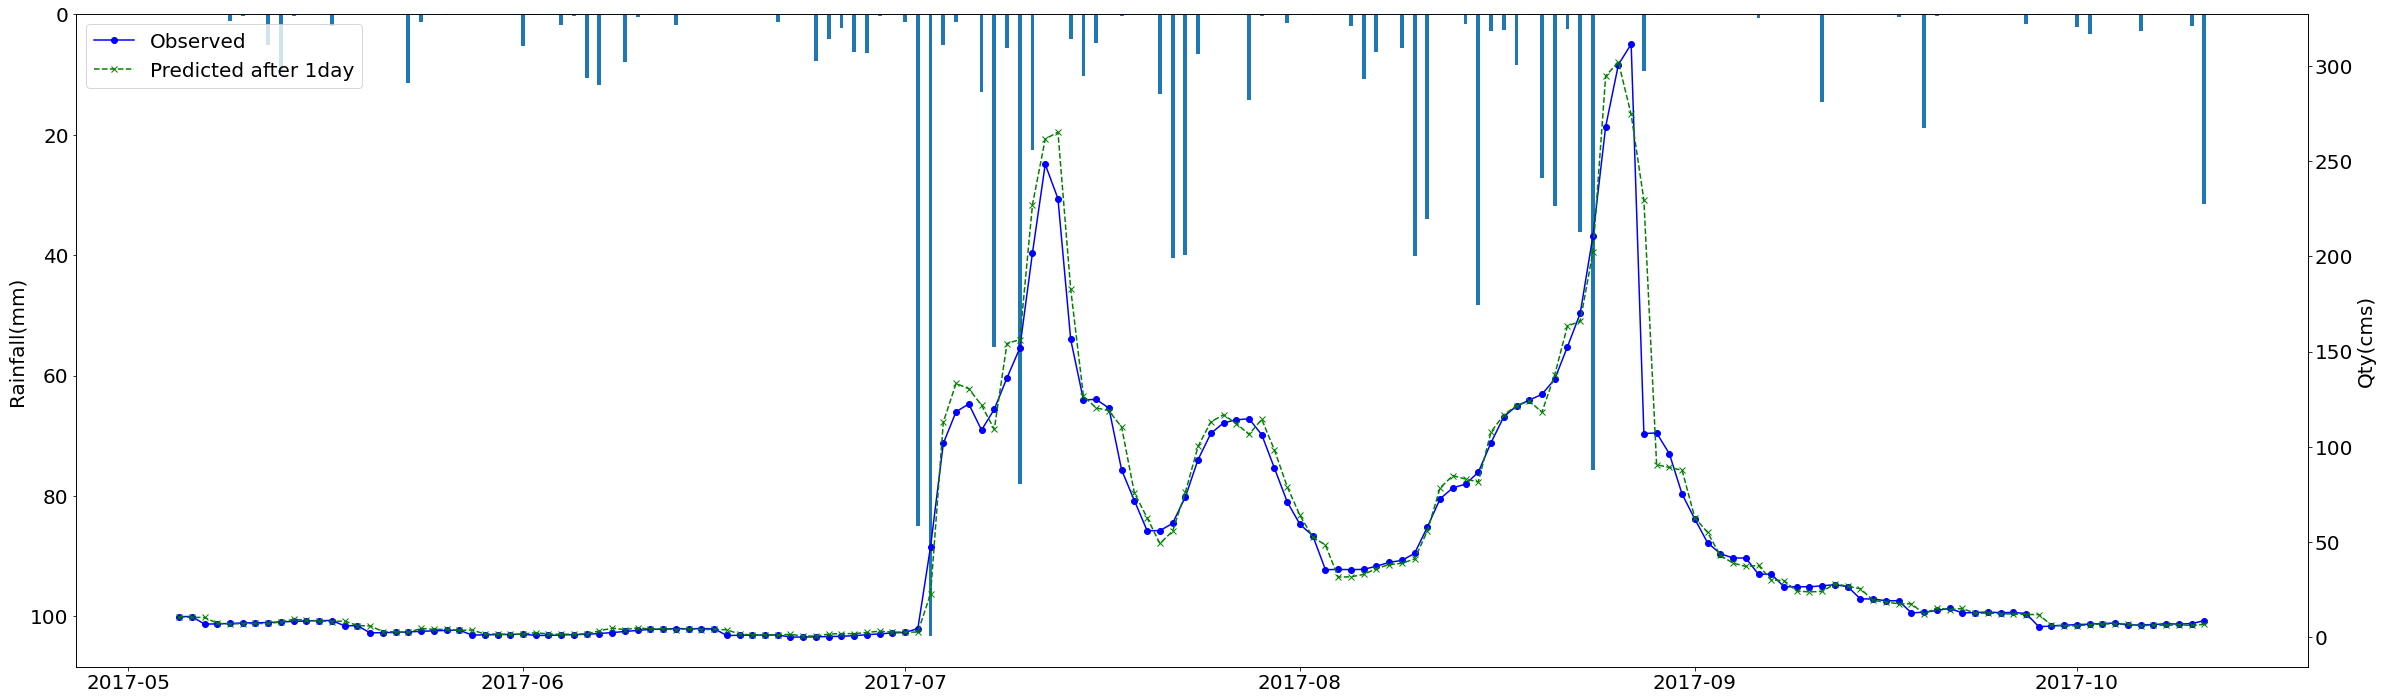

In [ ]:
#=============================================================
# 4. Digital Filtering 유출 성분 분리(지표 + 기저) 각각 학습하고 합쳐서 
#    유량과 비교하는 방법
#=============================================================


# 1). digital filter : separate from each component (base and run-off)

# 구글 드라이브 연결 (파일을 불러오기 위해 필요)
from google.colab import drive
drive.mount('/content/drive')

# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, RMSprop

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)

# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df_input = pd.read_csv(path + 'soyang.csv')
df_input


Q = df_input['IQTY'].to_numpy().flatten()
Q

a=0.95    #%baseflow filter parameter%

R = np.zeros(len(Q))
B = np.zeros(len(Q))
dif = np.zeros(len(Q))

for k in range(0, len(Q)-1):
  # 다음단계의 R은 현재 R * a와 Q의 변화량의 1/2 * (1+a)를 의미함
  #R(k+1)=a.*R(k)+((1+a).*(Q(k+1)-Q(k)))/2;
  R[k+1] = a * R[k] + ((1+a)*(Q[k+1] - Q[k]))/2
  
  # R이 0보다 작다면, 0으로 처리
  # if R(k+1)<0;
  #   R(k+1)=0;
  if R[k+1] < 0:
    R[k+1] = 0
  
  # R이 Q보다 크면 Q로 처리
  # if R(k+1)>Q(k+1);
  #   R(k+1)=Q(k+1);
  if R[k+1] > Q[k+1]:
    R[k+1] = Q[k+1]

  # B는 Q - R
  #B(k+1)=Q(k+1)-R(k+1);
  B[k+1] = Q[k+1] - R[k+1]

  # dif == R
  #dif(k+1)=Q(k+1)-B(k+1);
  dif[k+1] = Q[k+1] - B[k+1]

df = pd.DataFrame({'Q': Q, 'B': B, 'R': R, 'dif': dif, 'RF' : df_input['RF'] })
df


df[['Q', 'B', 'R']][3800:4000].plot(figsize=(20,8))


# 2). Predict Baseflow using LSTM


# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df[['B', 'RF']].copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 30
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'B'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
#print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
#print(dataset_y_reshaped)

#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)




# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음

drop_out_rate = 0.05

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x1 = LSTM(8, return_sequences=True, recurrent_dropout=drop_out_rate)(inputs) 
  x2 = LSTM(8, recurrent_dropout=drop_out_rate)(x1) 
  x3 = Dropout(drop_out_rate)(x2) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x3)
  model = Model(inputs=inputs, outputs=output)

  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
  
  
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_lstm(X_train, y_train)

y_pred = model_base.predict(X_test)
y_obs = y_test

df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15030:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df_input['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

#------------------------------------------
df_predict = df_pred[800:1000].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

#------------------------------------------


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, RMSprop

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)

# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df_input = pd.read_csv(path + 'soyang.csv')
df_input

Mounted at /content/drive
TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 17.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


1.15.2


,OBSYMD,DAMCD,RF,IQTY
0,19740101,1012110,0.0000,10.000
1,19740102,1012110,0.0000,9.000
2,19740103,1012110,0.0000,4.800
3,19740104,1012110,0.0000,6.100
4,19740105,1012110,0.0000,5.800
...,...,...,...,...
15985,20171007,1012110,0.1613,6.583
15986,20171008,1012110,0.0000,26.463
15987,20171009,1012110,0.0000,6.836
15988,20171010,1012110,1.9319,19.367
